In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator

5.7.1


In [2]:
#Enter the file path
path = './ScriptRuns/lows16FPGA_run2_part_thershold15001.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [3]:
def Sort(sub_li): 
    l = len(sub_li) 
    for i in range(0, l): 
        for j in range(0, l-i-1): 
            if (sub_li[j][1] > sub_li[j + 1][1]): 
                tempo = sub_li[j] 
                sub_li[j]= sub_li[j + 1] 
                sub_li[j + 1]= tempo 
    return sub_li 

In [4]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)

In [5]:
def SwapModule(slinks,SlinkAve,L1,L2):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=100000000
        flag=0
        for l in slinkHigh[1][1]: #loop on assigned lpgbt rates
            if abs((dif/2)-float(l[1])) < temp and dif > float(l[1]):
                lp=l[0] #lpgbt id l[1] lpgbt rate
                temp=abs((dif/2)-float(l[1]))
                flag=1
        #lp=Sort(slinkHigh[1][1])[0][0]
    
        if flag==1:
            for ilist,var in zip(L1,L2):
                if str(lp) in ilist:
                    var[str(lp),slinkHigh[0]].value=0
                    var[str(lp),slinkLow[0]].value=1
                else:
                    continue
            lowC-=1
            print("-------------OK--------------")
        print("-----------------------------")

In [6]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])
#print(Vars)
#print(Slink)


In [7]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

In [8]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 800.4831285416676
Std:  13.368369526614138
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 13.368369526614138


In [9]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

SwapModule(swapData(),GKavSlinkRate,L1,L2)

('170', [890.0939999999999, [[217, 103.9479], [124, 483.22479999999996], [362, 93.8175], [432, 98.5403], [655, 49.8219], [1268, 60.74159999999999]]])
('106', [759.4028000000001, [[449, 111.65169999999999], [256, 396.58900000000006], [551, 97.8414], [1129, 63.1881], [424, 90.1326]]])
-------------OK--------------
-----------------------------
('10', [852.11544, [[439, 126.8068], [936, 161.87369999999999], [77, 198.22500000000002], [766, 79.44829999999999], [1239, 91.39433], [460, 81.98100000000001], [1303, 49.8481], [781, 62.53821000000001]]])
('188', [764.2808, [[1010, 102.49589999999998], [89, 122.7546], [688, 205.90820000000002], [894, 157.361], [736, 77.2863], [1022, 98.4748]]])
-------------OK--------------
-----------------------------
('176', [850.5723, [[774, 101.75710000000001], [18, 122.45580000000001], [733, 157.2554], [472, 206.69279999999998], [1298, 97.32469999999999], [697, 44.2708], [462, 58.948499999999996], [1198, 61.8672]]])
('56', [765.3679, [[1101, 118.5527], [24, 1

In [10]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 800.4831285416676
Std:  7.967928289703184
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 7.967928289703184


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


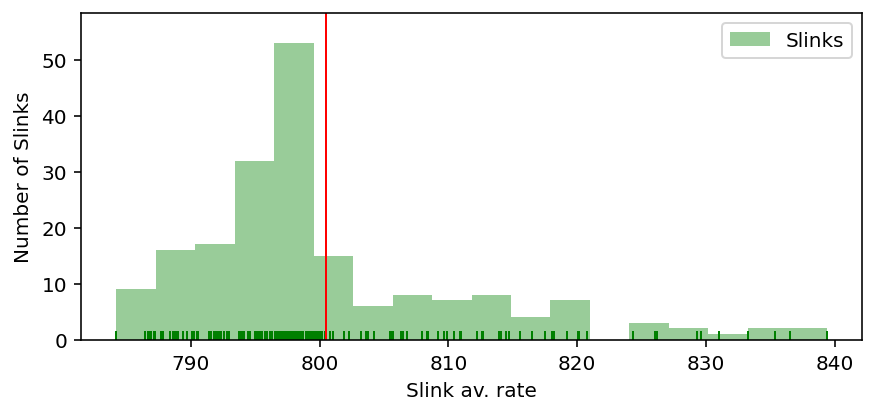

In [12]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
plt.savefig('16 fpga redistribution28fpga_.png')

In [13]:
# NOW SWAP ALGORİTHM

In [13]:
#BETTER ONE#
def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    highC=0
    #temp_low=lowC
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=ss[highC] #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=0
        flag=0
        temp_best=1000000
        #for s in ss:
            #if s!=slinkHigh:
            #slinkLow=s
        for l in slinkHigh[1][1]:

                #print(l)
            for k in slinkLow[1][1]:
                    
                if abs(float(l[1])-float(k[1]))<dif/2 and float(l[1])>float(k[1]): #and abs(GKavSlinkRate-abs(float(l[1])-float(k[1])))<temp_best:
                    #temp_best=abs(GKavSlinkRate-abs(float(l[1])-float(k[1]))
                        #temp=abs(float(l[1])-float(k[1]))
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==0:
            lowC-=1
                
            #lowC-=1
            #slinkLow=ss[lowC]
        if flag==1:
            #lowC=temp_low
            highC+=1
            lowC-=1                      
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
                else:
                    continue
            
            #ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
            print("-------------OK--------------")
        print("-----------------------------")
        #lowC-=1
        

In [12]:
#FIRST SWAP BEFORE BETTER ONE.
#DONT WORK THİS CELL

''''def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=0
        flag=0
        for l in slinkHigh[1][1]:
            #print(l)
            for k in slinkLow[1][1]:
                if abs(float(l[1])-float(k[1]))<dif/2 and abs(float(l[1])-float(k[1]))>temp and float(l[1])>float(k[1]):
                    #print('khmkmh')
                    temp=abs(float(l[1])-float(k[1]))
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==1:
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
                else:
                    continue
            lowC-=1
            print("-------------OK--------------")
        print("-----------------------------")

In [14]:
##### SWAP #######
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [15]:
L1_Swap=[]
L2_Swap=[]
for k, v in Vars.items():
    L1_Swap.append(v[0])
    L2_Swap.append(v[1])
    #print(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)


In [16]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1_Swap,L2_Swap):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

SwapModule2(swapData(),GKavSlinkRate,L1_Swap,L2_Swap)

('184', [839.3830999999999, [[1116, 103.2344], [1049, 123.98939999999999], [636, 167.1456], [414, 194.1344], [393, 95.3257], [833, 95.8434], [1242, 59.7102]]])
('151', [784.21971, [[457, 105.8179], [205, 142.5941], [406, 314.8528], [1222, 88.80134], [650, 74.6571], [1304, 57.49647]]])
-------------OK--------------
-----------------------------
('55', [836.57929, [[358, 118.447], [196, 375.1077], [916, 85.8966], [423, 97.6776], [734, 99.5413], [872, 59.909090000000006]]])
('156', [786.42753, [[956, 105.6527], [14, 142.4875], [436, 318.7926], [702, 101.5189], [1189, 62.242], [1151, 55.733830000000005]]])
-------------OK--------------
-----------------------------
('192', [835.3370899999999, [[330, 102.91199999999999], [335, 120.4824], [1004, 155.5504], [386, 209.97379999999998], [1147, 68.775], [1180, 55.3226], [840, 60.438689999999994], [1095, 61.8822]]])
('81', [786.4494500000001, [[173, 115.6707], [87, 150.36180000000002], [326, 228.8748], [1219, 63.939099999999996], [1293, 85.0109], 

In [17]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 800.4831285416676
Std:  5.840593134816606
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 5.840593134816606


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


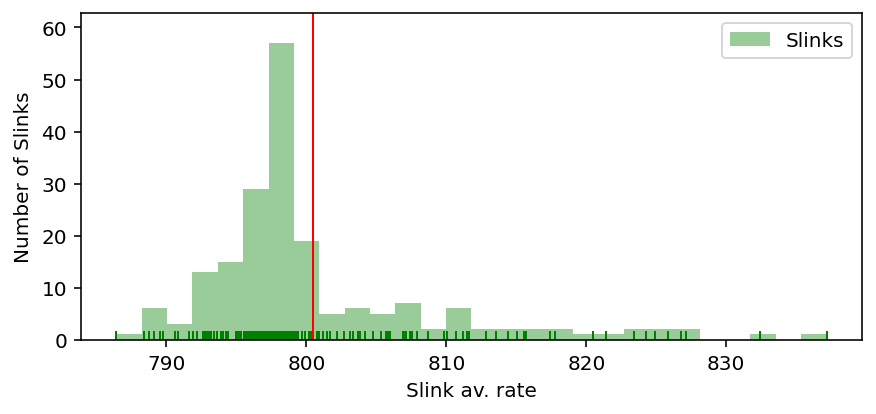

In [18]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1_Swap,L2_Swap):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
plt.savefig('16 fpga after old swap.png')

In [11]:
#first swap then redistribution

In [19]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 800.4831285416676
Std:  5.840593134816606
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 5.840593134816606


In [20]:
with open('./ScriptRuns/16_after_swap_S.pkl', mode='wb+') as file:
    cloudpickle.dump(model, file)